# Datos simulados de estabilidad de la red eléctrica

In [45]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.utils import resample 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.decomposition import PCA 

Okay, comenzaremos con el siguiente dataset que encontramos en [UCI](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data), las caracteristicas nos dicen lo siguiente según la presentación de [Slideshare](https://www.learnpytorch.io/).
$$
\tau[x] : \text{Tiempo de reacción del participante en un rango de 0.5 a 10 segundos.}
\\
p[x]: \text{Poder nominal consumido o producido}
\\
g[x]: \text{Coeficiente proporcional a la elasticidad del precio en un rango de 0.05 a 1} s^{-1}
\\
\text{stab: La parte real máxima de la raiz de la ecuación caracteristica, si es positiva el sistema es}
\\
\text{
linealmente inestable. }
$$

El proposito de está notebook  es hacer uso una Maquina de Soporte Vectorial para clasificar los datos en sus respectivas clases (estable o inestable).

A su vez se va a hacer uso de Optimización de parametros para dar a relucir lo bien que sirven las MSV desde su primer uso.


In [46]:
#Comenzamos creando un dataframe con los datos
df = pd.read_csv('ELECTRODATA\Data_for_UCI_named.csv', 
                 header=None)

In [47]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
1,2.95906002455997,3.07988520422811,8.38102539191882,9.78075443222607,3.76308477206316,-0.782603630987543,-1.25739482958732,-1.7230863114883,0.650456460887227,0.859578105752345,0.887444920638513,0.958033987602737,0.0553474891727752,unstable
2,9.3040972346785,4.90252411201167,3.04754072762177,1.36935735529605,5.06781210427845,-1.94005842705193,-1.87274168559721,-1.25501199162931,0.41344056837935,0.862414076352903,0.562139050527675,0.781759910653126,-0.00595746432603695,stable
3,8.97170690932022,8.84842842134833,3.04647874898866,1.21451813833956,3.40515818001095,-1.20745559234302,-1.27721014673295,-0.92049244093498,0.163041039311334,0.766688656526962,0.839444015400588,0.109853244952427,0.00347087904838871,unstable
4,0.716414776295121,7.66959964406565,4.48664083058949,2.34056298396795,3.96379106326633,-1.02747330413905,-1.9389441526466,-0.997373606480681,0.446208906537321,0.976744082924302,0.929380522872661,0.36271777426931,0.028870543444887,unstable


In [48]:
#Aqui nos damos cuenta de que necesitamos "limpiar" los datos.
df.columns = ["tau1","tau2","tau3","tau4","p1","p2","p3","p4","g1","g2","g3","g4","stab","Estabilidad"] #los etiquetamos 
dflimpio = df.drop(index=0).copy() #eliminamos la primera fila que no tiene datos y solo estorba
dflimpio.rename({'stabf' : 'Estabilidad'}, axis='columns', inplace=True) #renombramos la columna de estabilidad
dflimpio.Estabilidad = dflimpio.Estabilidad.eq('unstable').mul(1) #Aquí le ponemos 1 a unstable y 0 a stable
X = dflimpio.drop('Estabilidad', axis=1).copy() 
y = dflimpio['Estabilidad'].copy()

In [49]:
X.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
1,2.95906002455997,3.07988520422811,8.38102539191882,9.78075443222607,3.76308477206316,-0.782603630987543,-1.25739482958732,-1.7230863114883,0.650456460887227,0.859578105752345,0.887444920638513,0.958033987602737,0.0553474891727752
2,9.3040972346785,4.90252411201167,3.04754072762177,1.36935735529605,5.06781210427845,-1.94005842705193,-1.87274168559721,-1.25501199162931,0.41344056837935,0.862414076352903,0.562139050527675,0.781759910653126,-0.00595746432603695
3,8.97170690932022,8.84842842134833,3.04647874898866,1.21451813833956,3.40515818001095,-1.20745559234302,-1.27721014673295,-0.92049244093498,0.163041039311334,0.766688656526962,0.839444015400588,0.109853244952427,0.00347087904838871
4,0.716414776295121,7.66959964406565,4.48664083058949,2.34056298396795,3.96379106326633,-1.02747330413905,-1.9389441526466,-0.997373606480681,0.446208906537321,0.976744082924302,0.929380522872661,0.36271777426931,0.028870543444887
5,3.13411155161342,7.60877161603408,4.94375930178099,9.85757326996638,3.52581081652096,-1.12553095451115,-1.84597485447561,-0.554305007534195,0.797109525792467,0.455449947148291,0.656946658473716,0.820923486481631,0.0498603734837059


In [50]:
y.head()

1    1
2    0
3    1
4    1
5    1
Name: Estabilidad, dtype: int32

In [51]:
len(dflimpio) #su maquina, está gigante la base de datos

10000

In [52]:
dflimpio.Estabilidad.value_counts() #no más queria ver 

Estabilidad
1    6380
0    3620
Name: count, dtype: int64

In [53]:
#Volvemos a etiquetar, reducimos el tamaño de lo que vamos a usar
#y volvemos a unir los datos

df_estable = dflimpio[dflimpio['Estabilidad'] == 0]
df_inestable = dflimpio[dflimpio['Estabilidad'] == 1]
df_estable_downsampled = resample(df_estable,
                                  replace=False, # es para que no volvamos a uar los mismos datos
                                  n_samples=1000,
                                  random_state=42)
df_inestable_downsampled = resample(df_inestable,
                                  replace=False,
                                  n_samples=1000,
                                  random_state=42)
df_downsample = pd.concat([df_estable_downsampled, df_inestable_downsampled]) #listo

In [54]:
#Separamos los datos en X y y, es decir, las inputs y las outputs (lo que queremos predecir)
X = df_downsample.drop('Estabilidad', axis=1).copy() 
y = df_downsample['Estabilidad'].copy()

In [55]:
#Separamos los datos en training y testing
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train) #estandarizamos los datos
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
clf_svm = SVC(random_state=42) #creamos el clasificador
clf_svm.fit(X_train_scaled, y_train) #entrenamos el clasificador

SVC(random_state=42)

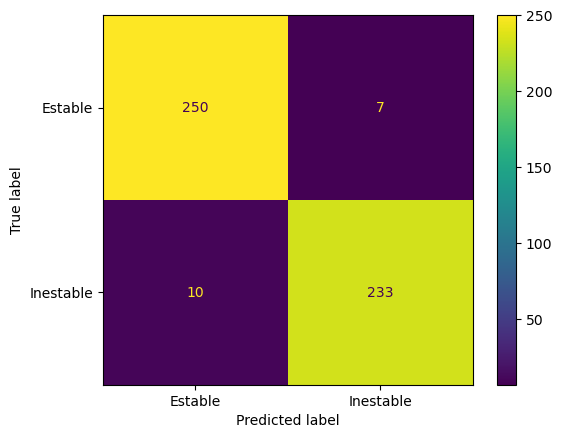

In [57]:
#Hacemos una predicción y visualizamos su desempeño con una matriz de confusión.
ConfusionMatrixDisplay.from_estimator(clf_svm, 
                                      X_test_scaled, 
                                      y_test,
                                      values_format='d',
                                      display_labels=["Estable", "Inestable"])       
                                                        

In [58]:
y_test.value_counts()
#Vemos que no le fue tan mal a nuestro SVM, pero podemos mejorar su desempeño (¿o no?)

Estabilidad
0    257
1    243
Name: count, dtype: int64

In [59]:
param_grid = [
  {'C': [0.5, 1, 10, 100], 
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]
optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.

In [60]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

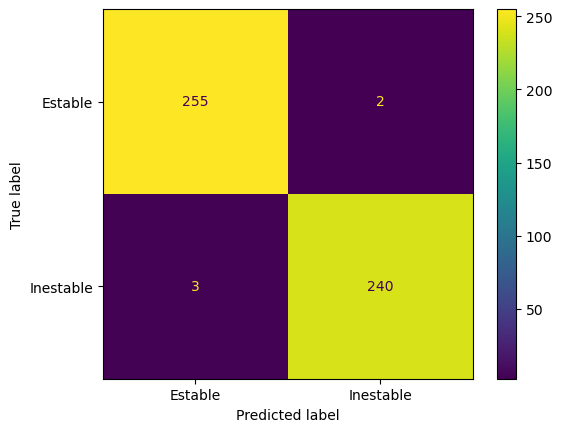

In [61]:
ConfusionMatrixDisplay.from_estimator(clf_svm, 
                                      X_test_scaled, 
                                      y_test,
                                      values_format='d',
                                      display_labels=["Estable", "Inestable"])

In [62]:
len(df_downsample.columns)

14

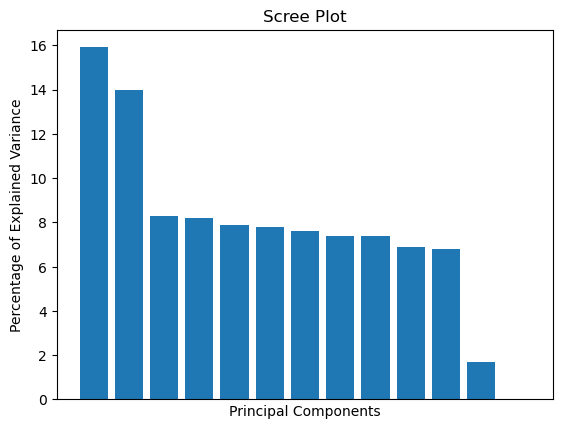

In [63]:
pca = PCA() # NOTE: By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [64]:
train_pc1_coords = X_train_pca[:, 0] 
train_pc2_coords = X_train_pca[:, 1]

## NOTE:
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

## Now center and scale the PCs...
pca_train_scaled = preprocessing.scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

## Now we optimize the SVM fit to the x and y-axis coordinates
## of the data after PCA dimension reduction...
param_grid = [
  {'C': [1, 10, 100, 1000], 
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy', # NOTE: The default value for scoring results in worse performance...
        ## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
    )

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


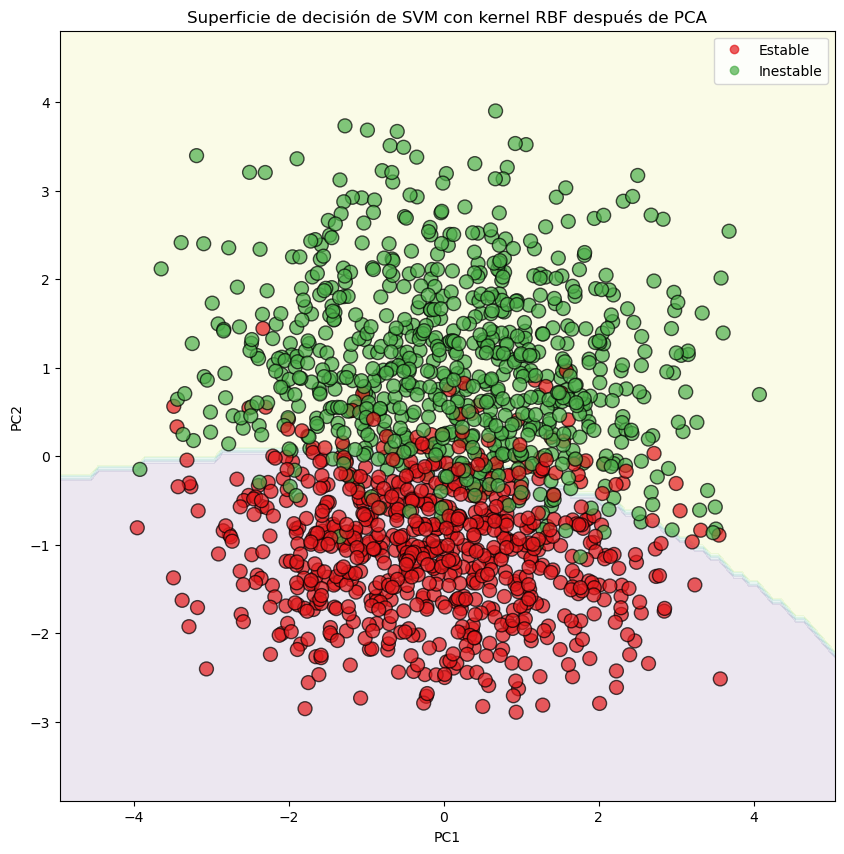

In [66]:
clf_svm = SVC(random_state=42, C=100, gamma=0.01)
clf_svm.fit(pca_train_scaled, y_train)

## Transform the test dataset with the PCA...
X_test_pca = pca.transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[:, 0] 
test_pc2_coords = X_test_pca[:, 1]

## Now create a matrix of points that we can use to show
## the decision regions.
## The matrix will be a little bit larger than the
## transformed PCA points so that we can plot all of
## the PCA points on it without them being on the edge
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

## now we will classify every point in that 
## matrix with the SVM. Points on one side of the 
## classification boundary will get 0, and points on the other
## side will get 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
## Right now, Z is just a long array of lots of 0s and 1s, which
## reflect how each point in the mesh was classified.
## We use reshape() so that each classification (0 or 1) corresponds
## to a specific point in the matrix.
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
## now we will use contourf() to draw a filled contour plot
## using the matrix values and classifications. 
## The contours will be filled according to the 
## predicted classifications (0s and 1s) in Z
ax.contourf(xx, yy, Z, alpha=0.1)

## now create custom colors for the actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
## now draw the actual data points - these will
## be colored by their known (not predcited) classifications
## NOTE: setting alpha=0.7 lets us see if we are covering up a point 
# scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_test, 
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train, 
               cmap=cmap, 
               s=100, 
               edgecolors='k', ## 'k' = black
               alpha=0.7)

## now create a legend
legend = ax.legend(scatter.legend_elements()[0], 
                   scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("Estable")
legend.get_texts()[1].set_text("Inestable")

## now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Superficie de decisión de SVM con kernel RBF después de PCA')
# plt.savefig('svm_default.png')
plt.show()